# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.392288,False,1.258390
1,0.197741,False,-0.219141
2,0.496427,True,5.910198
3,0.125173,True,4.240638
4,0.752525,True,5.961085
...,...,...,...
995,-0.933223,False,-2.580067
996,-1.168976,False,-0.521156
997,-0.405967,False,-1.629571
998,-1.008054,False,-1.999931


<Axes: xlabel='v0'>

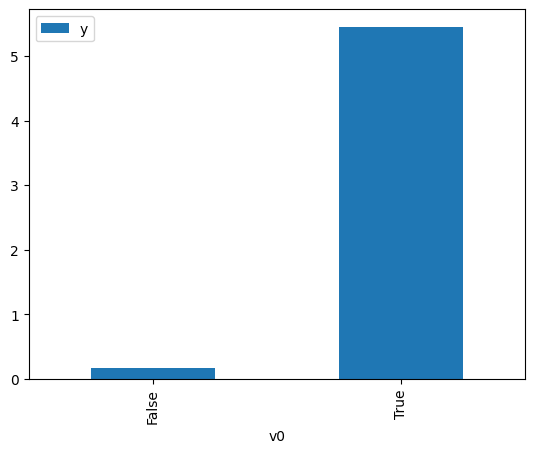

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

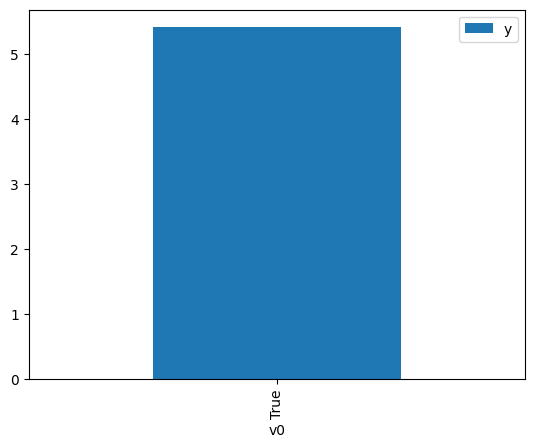

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.714149,False,0.482977,0.141243,7.079996
1,1.850575,False,3.394618,0.009650,103.627547
2,0.490049,False,1.104611,0.223097,4.482346
3,-0.650700,False,-0.077195,0.830496,1.204100
4,0.138008,False,1.156259,0.408000,2.450981
...,...,...,...,...,...
995,0.169160,False,-0.406469,0.389430,2.567857
996,-0.097159,False,-2.006676,0.552946,1.808495
997,-0.913651,False,-1.709957,0.904050,1.106133
998,-1.359998,False,-2.300483,0.966205,1.034977


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.046653,True,6.181600,0.994052,1.005984
1,-0.930208,True,4.919513,0.092437,10.818185
2,1.105351,True,5.948954,0.941468,1.062171
3,0.412320,True,6.443554,0.741620,1.348399
4,0.011018,True,5.389004,0.514106,1.945126
...,...,...,...,...,...
995,1.639581,True,6.701441,0.983800,1.016467
996,-0.531598,True,3.378509,0.215352,4.643555
997,-0.092236,True,2.428213,0.450082,2.221818
998,-0.941105,True,4.461628,0.090189,11.087867


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                          1.119e+04
Date:                Thu, 18 Jan 2024   Prob (F-statistic):                        0.00
Time:                        17:12:43   Log-Likelihood:                         -1400.7
No. Observations:                1000   AIC:                                      2805.
Df Residuals:                     998   BIC:                                      2815.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6411      0.035     46.855      0.000       1.572       1.710
x2             4.8991      0.050     98.917      0.000       4.802       4.996
==============================================================================
Omnibus:                        0.724   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.696   Jarque-Bera (JB):                0.809
Skew:                           0.044   Prob(JB):                        0.667
Kurtosis:                       2.893   Cond. No.                         1.94
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""